# Getting NetCDF from THREDDS OPeNDAP

Import necessary modules:
* netCDF4 for reading (and writing netCDF files)
* NumPy for multi-dimensional array manipulation
* matplotlib for plotting data

In [431]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

Jupyter Notebook line magic to allow matplotlib plots to be displayed in the notebook.

In [432]:
%matplotlib inline

Python functions for creating polygon geometries, based on parameters, for clipping gridded data.

Uses shapely module for creating geometries.

In [433]:
from shapely.geometry import Point, Polygon

Circle geometry function.

In [434]:
def circle_geometry(x, y, radius):
	p = Point(x, y)
	circle = p.buffer(radius)
	return circle

Triangle geometry function.

In [435]:
def triangle_geometry(x, y, distance):
	triangle = Polygon(shell=[(x - distance, y - distance),
	                          (x, y + distance),
	                          (x + distance, y - distance)],
	                   holes=None)  # Triangle
	return triangle

Rectangle geometry function.

In [436]:
def rectangle_geometry(x, y, length, height):
	rectangle = Polygon(shell=[(x - (length * 0.5), y - (height * 0.5)),
	                           (x - (length * 0.5), y + (height * 0.5)),
	                           (x + (length * 0.5), y + (height * 0.5)),
	                           (x + (length * 0.5), y - (height * 0.5))],
	                    holes=None)
	return rectangle

Cross geometry function.

In [437]:
def cross_geometry(x, y, distance, width):
	cross = Polygon(shell=[(x - distance, y - (distance * width)),
	                       (x - distance, y + (distance * width)),
	                       (x - (distance * width), y + (distance * width)),
	                       (x - (distance * width), y + distance),
	                       (x + (distance * width), y + distance),
	                       (x + (distance * width), y + (distance * width)),
	                       (x + distance, y + (distance * width)),
	                       (x + distance, y - (distance * width)),
	                       (x + (distance * width), y - (distance * width)),
	                       (x + (distance * width), y - distance),
	                       (x - (distance * width), y - distance),
	                       (x - (distance * width), y - (distance * width))],
	                holes=None)
	return cross

Diagonal cross geometry function.

In [438]:
def diagonal_cross_geometry(x, y, distance, width):
	diagonal_cross = Polygon(shell=[(x - distance, y - distance + (distance * width)),
	                                (x - (distance * width), y),
	                                (x - distance, y + distance - (distance * width)),
	                                (x - distance, y + distance),
	                                (x - distance + (distance * width), y + distance),
	                                (x, y + (distance * width)),
	                                (x + distance - (distance * width), y + distance),
	                                (x + distance, y + distance),
	                                (x + distance, y + distance - (distance * width)),
	                                (x + (distance * width), y),
	                                (x + distance, y - distance + (distance * width)),
	                                (x + distance, y - distance),
	                                (x + distance - (distance * width), y - distance),
	                                (x, y - (distance * width)),
	                                (x - distance + (distance * width), y - distance),
	                                (x - distance, y - distance)],
	                         holes=None)
	return diagonal_cross

Python function for creating a polygon geometry from a polygon shapefile.

Uses the geopandas module.

Dissolve item used to dissolve multiple polygons into a single polygon.

In [439]:
import geopandas

def shapefile_geometry(shapefile, dissolve_item):
	shape = geopandas.read_file(shapefile)
	shape_dissolved = shape.dissolve(by=dissolve_item)
	return shape_dissolved.ix[0].geometry

Define URL string for accessing PET data via OPeNDAP hosted on CEH THREDDS public catalog.

PET data is daily and organised in monthly netCDF files.

In [440]:
URL_TEMPLATE = 'http://gds-ldb.nerc-lancaster.ac.uk/thredds/dodsC/PETDetail/chess_pet_wwg_{year:04d}{month:02d}.nc'

Define year and month and create URL for an individual netCDF file.

In [441]:
year = 2010
month = 5
url = URL_TEMPLATE.format(year=year, month=month)

print('url:\t\t{0}'.format(url))

url:		http://gds-ldb.nerc-lancaster.ac.uk/thredds/dodsC/PETDetail/chess_pet_wwg_201005.nc


Create netCDF4 dataset object for selected netCDF file.

Print dataset information.  Shows global attributes, dimensions, variables, and groups (none in the selected file).

In [442]:
dataset = nc.Dataset(url)  # open the dataset
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    title: Potential evapotranspiration over well-watered grass.
    institution: CEH Wallingford - NERC
    geospatial_lat_min: 49.770996
    geospatial_lat_max: 59.395187
    geospatial_lon_min: -9.004521
    geospatial_lon_max: 2.491239
    time_coverage_start: 2010-05-01
    time_coverage_end: 2010-05-31
    version: 1.2
    Conventions: CF-1.6
    description: Daily potential evapotranspiration (mm/day) at 1km resolution over Great Britain. Calculated using the Penman-Monteith equation assuming a well-watered grass surface.
    date_created: 2015-09-24
    creator_name: Eleanor Blyth, Douglas Clark, Jon Finch, Emma Robinson, Alison Rudd
    creator_email: chess@ceh.ac.uk
    publisher_name: Centre for Ecology and Hydrology
    publisher_url: http://www.ceh.ac.uk
    publisher_email: enquiries@ceh.ac.uk
    source: Climate Hydrology Ecosystem research Support System (CHESS)
    licence: Li

NetCDF data file has:
* many global attributes
* three dimensions
  * time - 31 time steps
  * y - 1057 rows
  * x - 656 columns
* seven variables
  * time (31 time steps)
  * y (1057 rows)
  * x (656 columns)
  * crs - coordinate reference system
  * lat (1057 rows × 656 columns)
  * lon (1057 rows × 656 columns)
  * pet (31 time steps × 1057 rows × 656 columns)

Plot gridded data for the PET variable.

Data plotted is for the first time step - 1 May 2010 - for the full spatial extent (1057 rows × 656 columns).

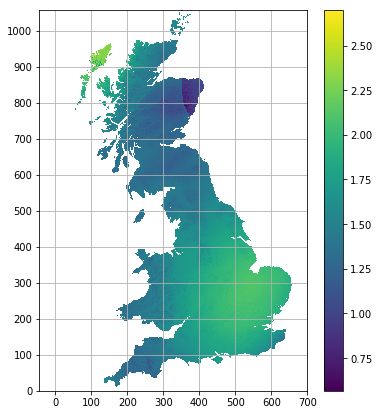

In [443]:
plt.figure(figsize=(6,7))
plt.imshow(dataset['pet'][0, :, :], origin='lower')
plt.colorbar()
plt.xticks(np.arange(0, 800, 100))
plt.yticks(np.arange(0, 1100, 100))
plt.axis("equal")
plt.grid(True)
plt.show()

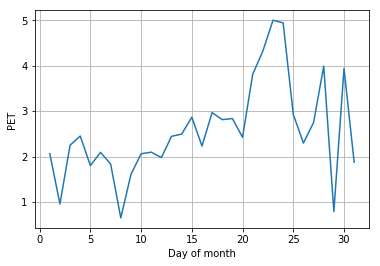

In [444]:
PET = dataset['pet'][:, 200, 500]
plt.plot(np.arange(1, len(PET) + 1), PET)
plt.xlabel('Day of month')
plt.ylabel('PET')
plt.grid(True)
plt.show()

Define centre point for clipping geometry.

In [445]:
# x, y = 450000.0, 96000.0 # Isle of Wight (british National Grid coordinates)
x, y = 200000.0, 800000.0 # West Scotland (British National Grid coordinates)

Create clipping geometry using centre point and a geometry function.

In [446]:
# geometry = circle_geometry(x=x,
#                            y=y,
#                            radius=150000.0)
# geometry = triangle_geometry(x=x,
#                              y=y,
#                              distance=150000.0)
# geometry = rectangle_geometry(x=x,
#                               y=y,
#                               length=225000.0,
#                               height=125000.0)
# geometry = cross_geometry(x=x,
#                           y=y,
#                           distance=100000.0,
#                           width=0.3)
geometry = diagonal_cross_geometry(x=x,
                                   y=y,
                                   distance=100000.0,
                                   width=0.4)
print(geometry)

POLYGON ((100000 740000, 160000 800000, 100000 860000, 100000 900000, 140000 900000, 200000 840000, 260000 900000, 300000 900000, 300000 860000, 240000 800000, 300000 740000, 300000 700000, 260000 700000, 200000 760000, 140000 700000, 100000 700000, 100000 740000))


Alternatively create a polygon geometry from a shapefile.

In [447]:
# shapefile_filepath = r'G:\endows\accessing-netcdf-data-by-coordinates\shapefiles\bedfordshire.shp'
# shapefile_filepath = r'G:\endows\accessing-netcdf-data-by-coordinates\shapefiles\highland.shp'
# geometry = shapefile_geometry(shapefile=shapefile_filepath,
#                              dissolve_item='COMMENT_')
# print(geometry)

Convert the bounding box of the polygon geometry into array coordinates.

In [448]:
index = lambda x,y: (int(x // 1000), int(y // 1000))

bounds = geometry.bounds
print('bounds:\t\t{0}'.format(bounds))

ll = index(*bounds[0:2])  # lower left
ur = index(*bounds[2:4])  # upper right
print('ll:\t\t{0}'.format(ll))
print('ur:\t\t{0}'.format(ur))

bounds:		(100000.0, 700000.0, 300000.0, 900000.0)
ll:		(100, 700)
ur:		(300, 900)


Get 2D slice of data for the first time step for array pixels within the transformed array coordinates.

Print 2D slice shape and summary statistics.

In [449]:
data = dataset['pet'][0, ll[1]:ur[1],ll[0]:ur[0]]

print('data.shape:\t\t{0}'.format(data.shape))
print('data.min():\t\t{0}'.format(data.min()))
print('data.max():\t\t{0}'.format(data.max()))
print('data.mean():\t\t{0}'.format(data.mean()))
print('data.std():\t\t{0}'.format(data.std()))

data.shape:		(200, 200)
data.min():		0.989684522151947
data.max():		2.3715176582336426
data.mean():		1.439880778633196
data.std():		0.2032154028963812


Define affine transformation to allow transformation between array coordinates and geographic coordinates.

This will be used when masking a subset of the netCDF data.

For the PET dataset 1 pixel is 1000 × 1000 m.

In [450]:
from affine import Affine

xoff = ll[0]
yoff = ll[1]

# affine transformation from pixel coordinates to geographic coordinates
# 1 pixel = 1000m x 1000m
# the offset is needed because we're masking a subset of the dataset
a = 1000        # change in x with x
b = 0           # change in y with x
c = xoff * 1000 # x offset
d = 0           # change in y with x
e = 1000        # change in y with y
f = yoff * 1000 # y offset

shifted_affine = Affine(a, b, c, d, e, f)
print('shifted_affine:\n{0}'.format(shifted_affine))

shifted_affine:
| 1000.00, 0.00, 100000.00|
| 0.00, 1000.00, 700000.00|
| 0.00, 0.00, 1.00|


Convert polygon clipping geometry to a raster.

Uses the rasterio module.

Pixels in the polygon equal 0 (i.e. unmasked) and those outside equal 1 (i.e. masked).

Rasterise method includes pixels touching the geometry (all_touched=True).

In [451]:
import rasterio.features

mask = rasterio.features.rasterize(shapes=[(geometry, 0)],
                                   out_shape=data.shape,
                                   fill=1,
                                   transform=shifted_affine,
                                   all_touched=True,
                                   dtype=np.uint8)

Plot mask.

Need to flip the mask array to display properly with matplotlib.

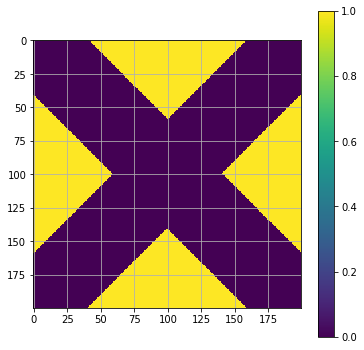

In [452]:
plt.figure(figsize=(6, 6))
plt.imshow(np.flipud(mask))
plt.colorbar()
plt.grid(True)
plt.show()

Ensure the data slice is a NumPy masked array.

NetCDF4 module should read in gridded data as a NumPy masked array if missing values defined in the NetCDF file.

In [453]:
data = np.ma.array(data)

Plot 2D data slice.

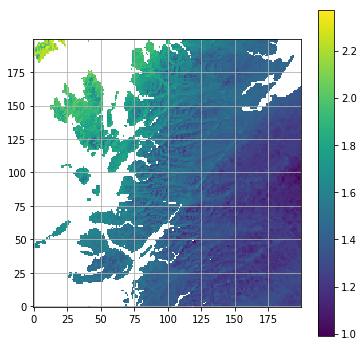

In [454]:
plt.figure(figsize=(6, 6))
plt.imshow(data, origin='lower', interpolation='nearest')
plt.colorbar()
plt.grid(True)
plt.show()

Apply the mask using a bitwise OR.

In [455]:
data.mask = data.mask | mask

Plot the masked data slice.

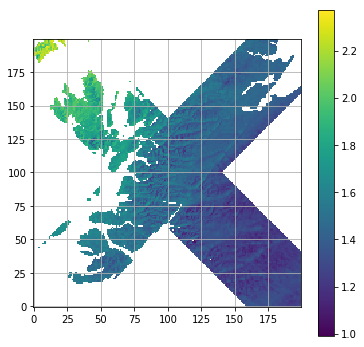

In [456]:
plt.figure(figsize=(6, 6))
plt.imshow(data, origin='lower', interpolation='nearest')
plt.colorbar()
plt.grid(True)
plt.show()

Create a 3D mask from the 2D mask using NumPy broadcasting.

In [457]:
field3d = np.zeros(shape=(dataset['pet'].shape[0], data.shape[0], data.shape[1]),
                   dtype=np.float32)
field3d_mask = np.broadcast_to(mask, field3d.shape)

Get 3D cube of data - for all timesteps and for the transformed array coordinates.

Print 3D cube shape and summary statistics.

In [458]:
data3d = dataset['pet'][:, ll[1]:ur[1],ll[0]:ur[0]]

print('data3d.shape:\t\t{0}'.format(data3d.shape))
print('np.min(data3d):\t\t{0}'.format(np.min(data3d)))
print('np.max(data3d):\t\t{0}'.format(np.max(data3d)))
print('np.mean(data3d):\t{0}'.format(np.mean(data3d)))
print('np.std(data3d):\t\t{0}'.format(np.std(data3d)))

data3d.shape:		(31, 200, 200)
np.min(data3d):		0.32056885957717896
np.max(data3d):		4.24540901184082
np.mean(data3d):	2.010372467829622
np.std(data3d):		0.5917107246698649


Ensure the 3D data cube is a NumPy masked array.

In [459]:
data3d = np.ma.array(data3d)

print('type(data3d):\t\t{0}'.format(type(data3d)))
print('\ndata3d.shape:\t\t{0}'.format(data3d.shape))
print('np.ma.min(data3d):\t{0}'.format(np.ma.min(data3d)))
print('np.ma.max(data3d):\t{0}'.format(np.ma.max(data3d)))
print('np.ma.mean(data3d):\t{0}'.format(np.ma.mean(data3d)))
print('np.ma.std(data3d):\t{0}'.format(np.ma.std(data3d)))

type(data3d):		<class 'numpy.ma.core.MaskedArray'>

data3d.shape:		(31, 200, 200)
np.ma.min(data3d):	0.32056885957717896
np.ma.max(data3d):	4.24540901184082
np.ma.mean(data3d):	2.010372467829622
np.ma.std(data3d):	0.5917107246698649


Plot slices of the 3D data cube.

Uses matplotlib subplots for each time slice.

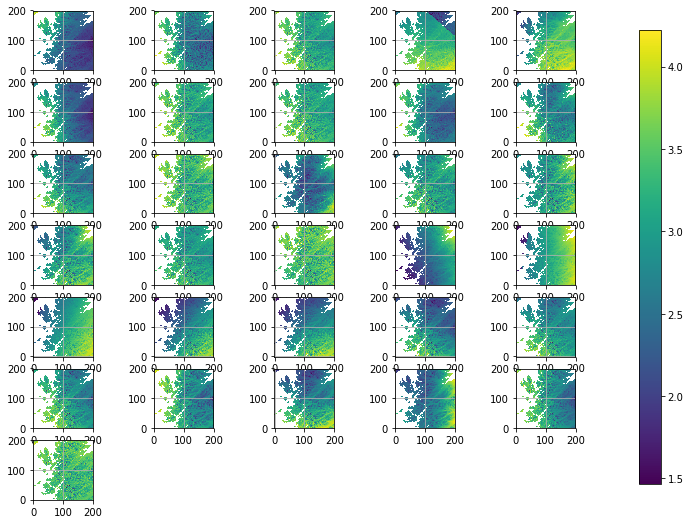

In [460]:
fig = plt.figure(figsize=(12, 9))
for n in range(data3d.shape[0]):
    ax = fig.add_subplot(7, 5, n + 1)
    im = ax.imshow(data3d[n], origin='lower', interpolation='nearest')
    ax.grid(True)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Mask 3D data cube with 3D mask using a bitwise OR.

In [461]:
data3d.mask = data3d.mask | field3d_mask

print('data3d.shape:\t\t{0}'.format(data3d.shape))
print('\nnp.ma.min(data3d):\t{0}'.format(np.ma.min(data3d)))
print('np.ma.max(data3d):\t{0}'.format(np.ma.max(data3d)))
print('np.ma.mean(data3d):\t{0}'.format(np.ma.mean(data3d)))
print('np.ma.std(data3d):\t{0}'.format(np.ma.std(data3d)))

data3d.shape:		(31, 200, 200)

np.ma.min(data3d):	0.32056885957717896
np.ma.max(data3d):	4.24540901184082
np.ma.mean(data3d):	2.0174260576760683
np.ma.std(data3d):	0.5934302131228529


Plot masked slices of the 3D data cube.

Uses matplotlib subplots for each time slice.

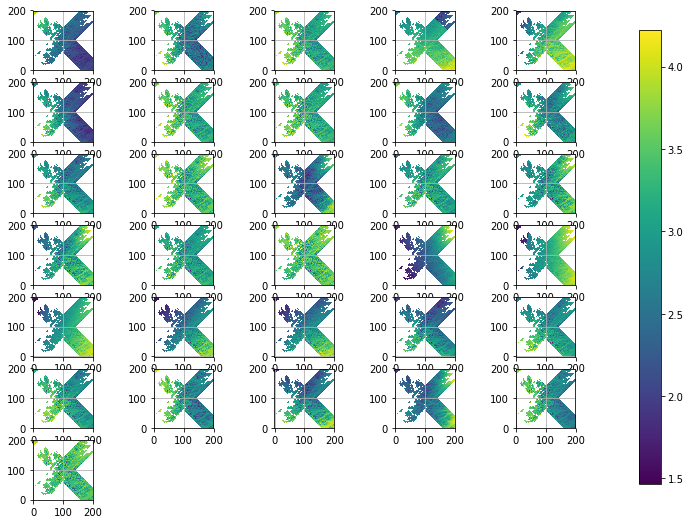

In [462]:
fig = plt.figure(figsize=(12, 9))
for n in range(data3d.shape[0]):
    ax = fig.add_subplot(7, 5, n + 1)
    im = ax.imshow(data3d[n], origin='lower', interpolation='nearest')
    ax.grid(True)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

Close NetCDF dataset object.

In [463]:
dataset.close()